# Eksploracyjna analiza danych, inżynieria cech oraz trenowanie modelu

### Import bibliotek

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.seasonal import STL
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from copy import deepcopy

In [2]:
# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the src directory to the Python path
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

### Połączenie z bazą danych i wczytanie danych

In [3]:
from data.DBServer import DBServer

server = DBServer(
    server='DESKTOP-SFO3K5V',
    user = 'user_1',
    password = '9',
    database = 'BI_project'
)
server.db_connect()
server.db_create_cursor()

In [4]:
command = """SELECT e.ID, e.effective_date, e.no, e.bid, e.ask, e.currency_ID, c.code, c.currency
    FROM exchange e
    JOIN currency c
        ON e.currency_id = c.ID
    WHERE c.code <> 'XDR'"""

columns = ['ID', 'effective_date', 'no', 'bid', 'ask', 'currency_ID', 'code', 'currency']
df = pd.DataFrame(server.execute_command(command),columns=columns)


In [5]:
df.head(5)

,ID,effective_date,no,bid,ask,currency_ID,code,currency
0,1,2005-01-03,1/C/NBP/2005,2.960500,3.020300,12,USD,dolar amerykański
1,2,2005-01-03,1/C/NBP/2005,4.038200,4.119800,6,EUR,euro
2,3,2005-01-03,1/C/NBP/2005,2.308000,2.354600,1,AUD,dolar australijski
3,4,2005-01-03,1/C/NBP/2005,0.016424,0.016756,8,HUF,forint węgierski
4,5,2005-01-03,1/C/NBP/2005,2.615700,2.668500,3,CHF,frank szwajcarski


Wartości brakujące

In [8]:
df.isna().sum()

ID                0
effective_date    0
no                0
bid               0
ask               0
currency_ID       0
code              0
currency          0
dtype: int64

Dane nie zawierają wartości brakujących

Typy danych:

In [9]:
df.dtypes

ID                  int64
effective_date     object
no                 object
bid               float64
ask               float64
currency_ID         int64
code               object
currency           object
dtype: object

Typ danych jest poprawny dla wszystkich kolumn z wyjątkiem effective_date, która zostanie przekonwertowana do datetime

In [10]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.dtypes

ID                         int64
effective_date    datetime64[ns]
no                        object
bid                      float64
ask                      float64
currency_ID                int64
code                      object
currency                  object
dtype: object

### EDA

Wartości średnie wg waluty

In [11]:
mean_df = pd.DataFrame(df.groupby('code')['bid'].mean())
mean_df.sort_values(by='bid')

,bid
code,
HUF,0.013695
JPY,0.031963
CZK,0.159392
SEK,0.427017
NOK,0.467127
DKK,0.558455
AUD,2.715728
CAD,2.872067
USD,3.426590


Wartości te odpowiadają realnym kursom, co wskazuje, że dane zostały poprawnie wczytane

### Kształtowanie się kursów poszczególnych walut na przestrzeni lat

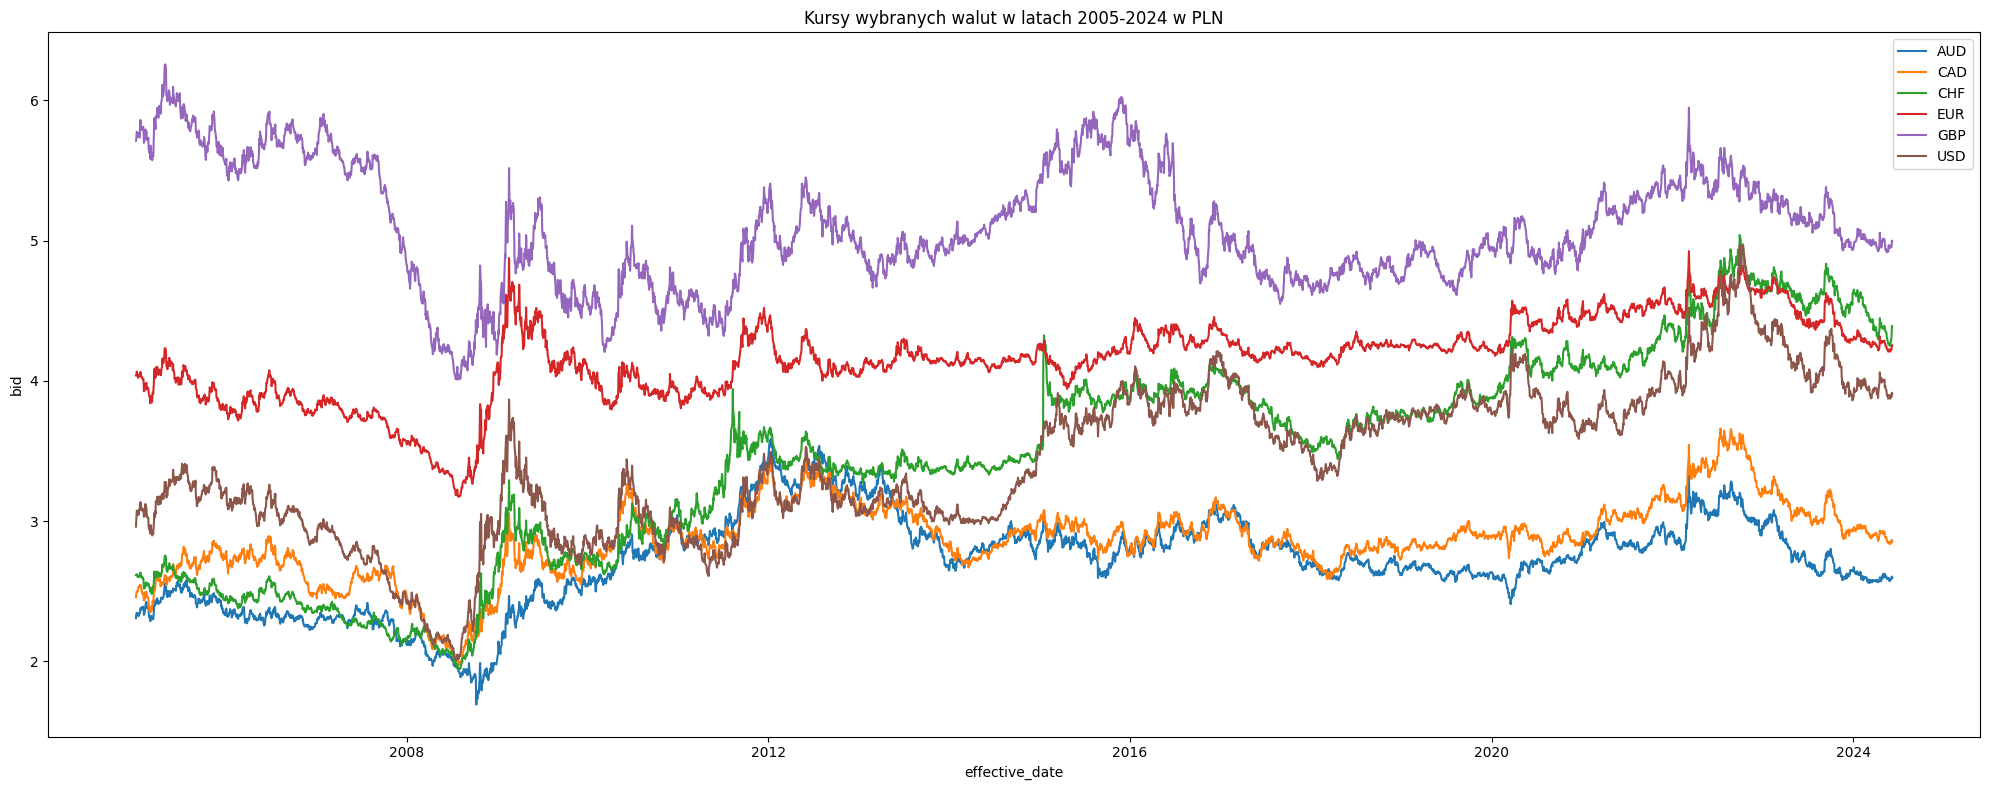

In [12]:

codes_high = mean_df[mean_df['bid'] > 1].index
fig,ax = plt.subplots(1,1,figsize=(20,8))
for code in codes_high:
    df_temp = df[df['code'] == code]
    sns.lineplot(x=df_temp['effective_date'],y=df_temp['bid'],ax=ax,label = code)
ax.set_title('Kursy wybranych walut w latach 2005-2024 w PLN')
plt.tight_layout()
plt.show()

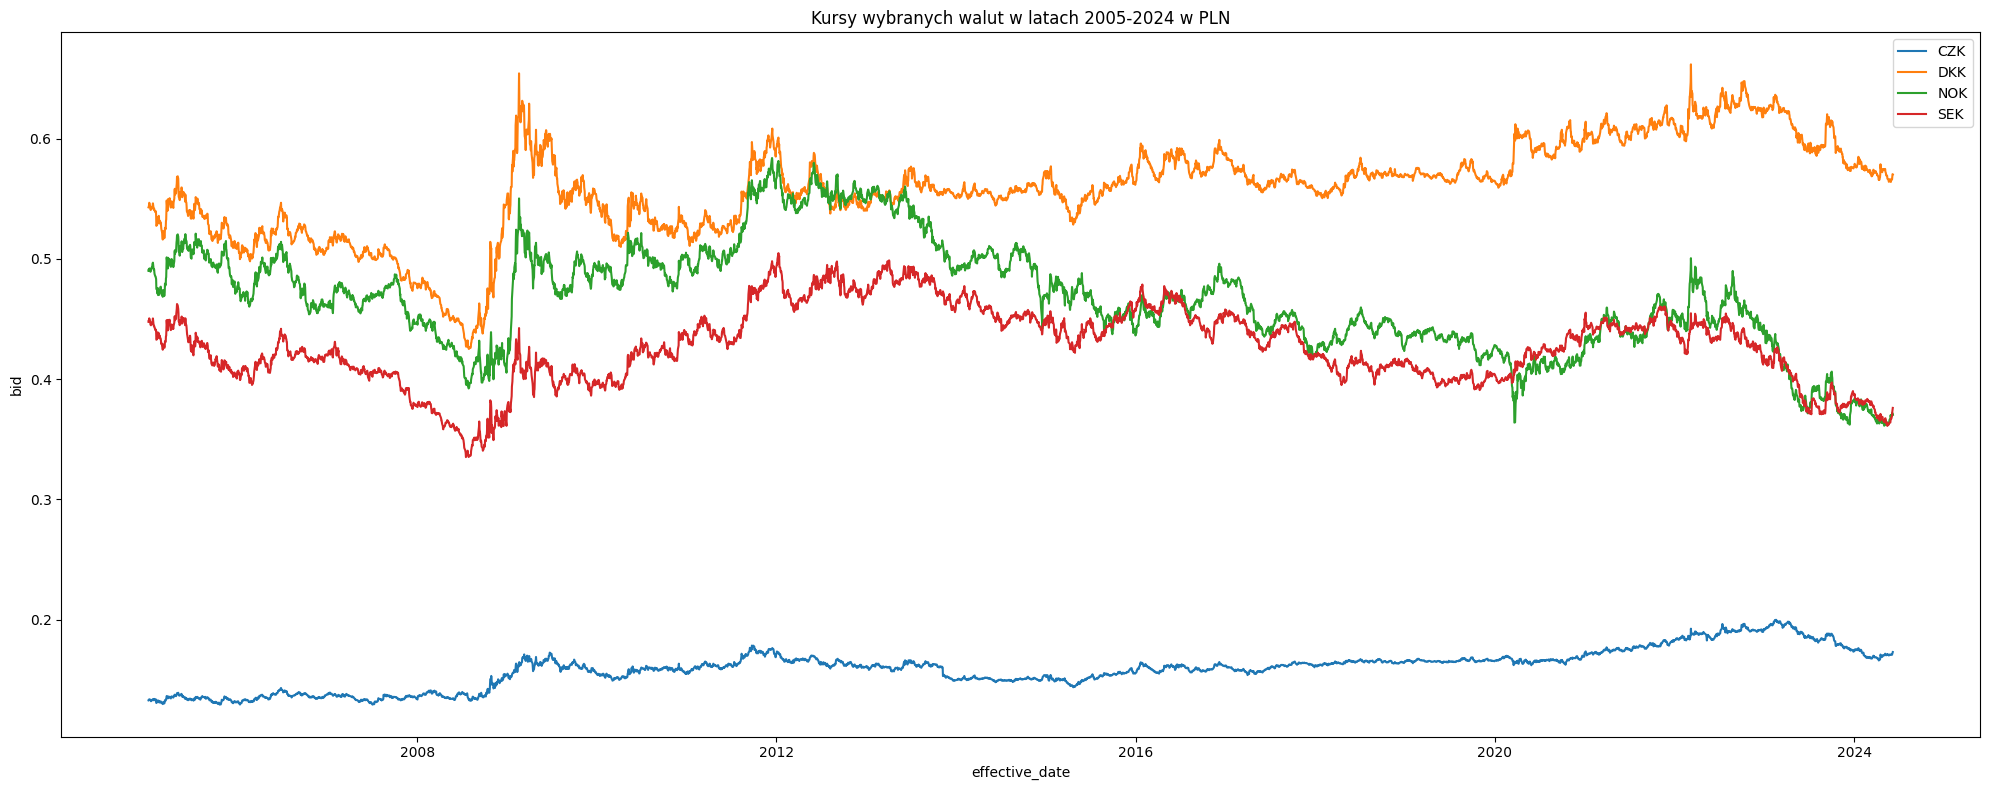

In [13]:
codes_low = mean_df[(mean_df['bid'] < 1) & (mean_df['bid'] > 0.1)].index
fig,ax = plt.subplots(1,1,figsize=(20,8))
for code in codes_low:
    df_temp = df[df['code'] == code]
    sns.lineplot(x=df_temp['effective_date'],y=df_temp['bid'],ax=ax,label = code)

ax.set_title('Kursy wybranych walut w latach 2005-2024 w PLN')
plt.tight_layout()
plt.show()

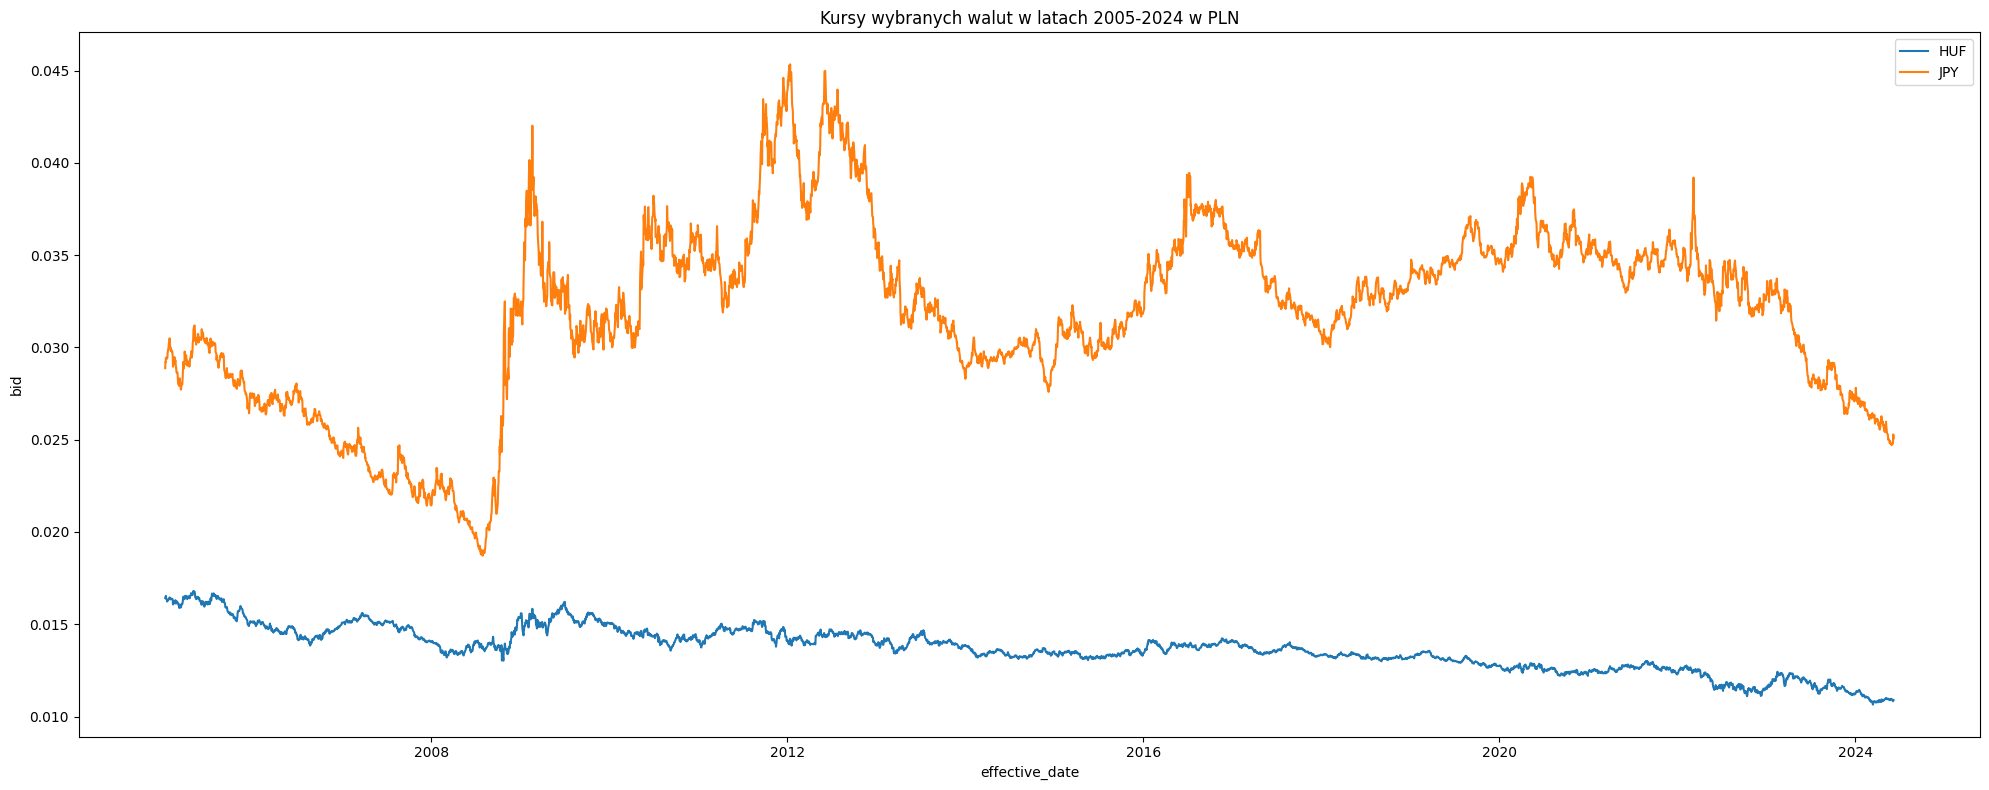

In [14]:
codes_low = mean_df[mean_df['bid'] < 0.1].index
fig,ax = plt.subplots(1,1,figsize=(20,8))
for code in codes_low:
    df_temp = df[df['code'] == code]
    sns.lineplot(x=df_temp['effective_date'],y=df_temp['bid'],ax=ax,label = code)

ax.set_title('Kursy wybranych walut w latach 2005-2024 w PLN')
plt.tight_layout()
plt.show()

Dla niemal wszystkich walut widoczne są bardzo wyraźnie 2 wydarzenia - kryzys finansowy z roku 2008, który doprowadził do osłabienia złotówki i wzrostu kursów, a także wybuch wojny na Ukrainie w roku 2022, który podobnie wpłynął na nagłe osłabienie złotówki. Warto zauważyć, że peak z 2022 roku jest słabo widoczny kursach korony czeskiej oraz węgierskiego. Są to kraje podobnie jak Polska niewiele oddalone od frontu co przypuszczalnie sprawiło, że ich waluty również uległy osłabieniu wskutek wybuchu wojny.
Ponadto, w kursie brytyjskiego funta widoczny jest wzrost i spadek wartości w okolicach roku 2016 co przypuszczalnie jest związane z Brexitem.

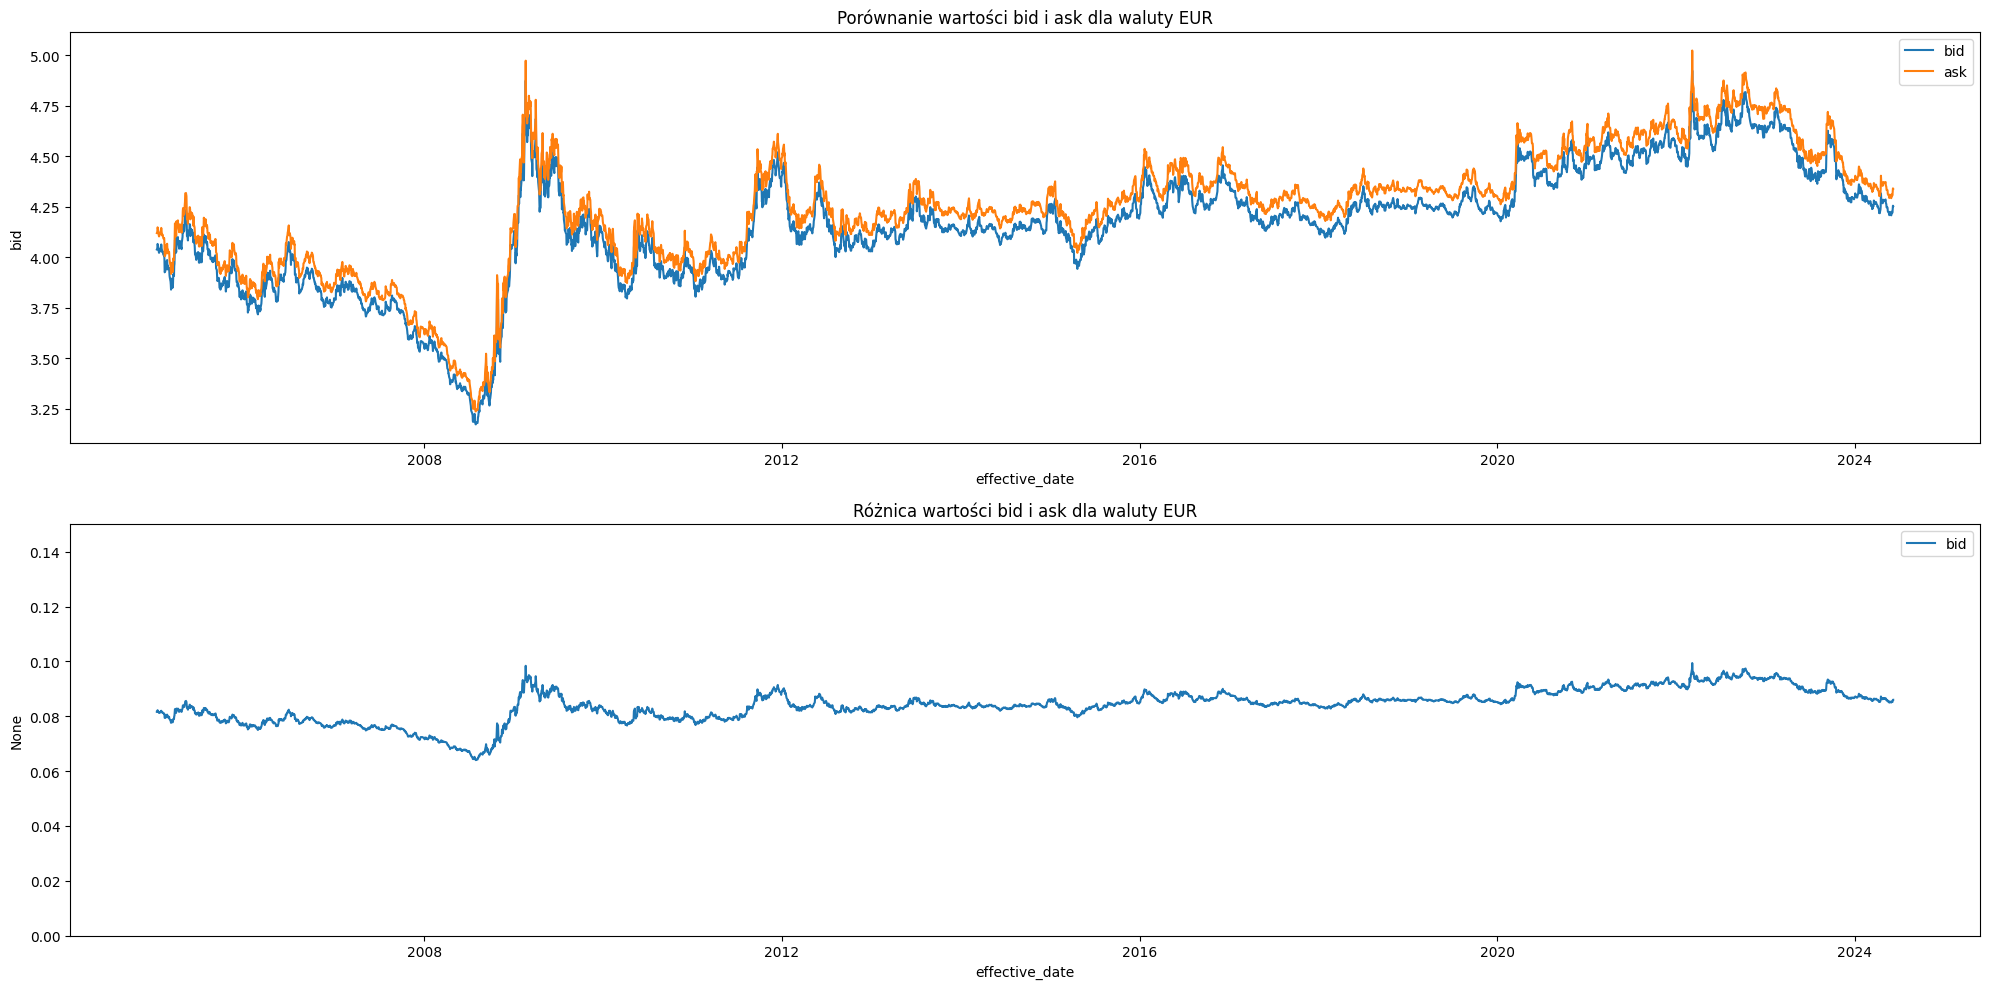

In [15]:

fig,ax = plt.subplots(2,1,figsize=(20,10))
df_temp = df[df['code'] == 'EUR']
sns.lineplot(x=df_temp['effective_date'],y=df_temp['bid'],ax=ax[0],label = 'bid')
sns.lineplot(x=df_temp['effective_date'],y=df_temp['ask'],ax=ax[0],label = 'ask')

ax[0].set_title('Porównanie wartości bid i ask dla waluty EUR')

sns.lineplot(x=df_temp['effective_date'],y=df_temp['ask'] - df_temp['bid'],ax=ax[1],label = 'bid')
ax[1].set_title('Różnica wartości bid i ask dla waluty EUR')
ax[1].set_ylim([0, 0.15])
plt.tight_layout()
plt.show()

Widoczne jest, że wartości te charakteryzują się tym samym trendem, a różnica między nimi oscyluje w granicach od ok 6 do 10 groszy dla Euro.

Dodanie wartości średniej bid i ask jako tej, która będzie analizowana.

In [16]:
df['rate'] = (df['bid'] + df['ask'])/2
df


,ID,effective_date,no,bid,ask,currency_ID,code,currency,rate
0,1,2005-01-03,1/C/NBP/2005,2.960500,3.020300,12,USD,dolar amerykański,2.990400
1,2,2005-01-03,1/C/NBP/2005,4.038200,4.119800,6,EUR,euro,4.079000
2,3,2005-01-03,1/C/NBP/2005,2.308000,2.354600,1,AUD,dolar australijski,2.331300
3,4,2005-01-03,1/C/NBP/2005,0.016424,0.016756,8,HUF,forint węgierski,0.016590
4,5,2005-01-03,1/C/NBP/2005,2.615700,2.668500,3,CHF,frank szwajcarski,2.642100
...,...,...,...,...,...,...,...,...,...
58903,63897,2024-06-06,109/C/NBP/2024,0.025076,0.025582,9,JPY,jen japoński,0.025329
58904,63898,2024-06-06,109/C/NBP/2024,0.173000,0.176400,4,CZK,korona czeska,0.174700
58905,63899,2024-06-06,109/C/NBP/2024,0.570200,0.581800,5,DKK,korona duńska,0.576000
58906,63900,2024-06-06,109/C/NBP/2024,0.370100,0.377500,10,NOK,korona norweska,0.373800


## Feature Engineering

### Cechy związane z datą

In [19]:
df.loc[:,'year'] = df['effective_date'].dt.year
df.loc[:,'day_of_year'] = df['effective_date'].dt.day_of_year
df.loc[:,'month'] = df['effective_date'].dt.month
df.loc[:,'day'] = df['effective_date'].dt.day
df.loc[:,'day_of_week'] = df['effective_date'].dt.weekday
df.loc[:,'week_of_year'] = df['effective_date'].dt.strftime("%W").apply(lambda x: int(x))
df.head(5)

,ID,effective_date,no,bid,ask,currency_ID,code,currency,rate,year,day_of_year,month,day,day_of_week,week_of_year
0,1,2005-01-03,1/C/NBP/2005,2.960500,3.020300,12,USD,dolar amerykański,2.99040,2005,3,1,3,0,1
1,2,2005-01-03,1/C/NBP/2005,4.038200,4.119800,6,EUR,euro,4.07900,2005,3,1,3,0,1
2,3,2005-01-03,1/C/NBP/2005,2.308000,2.354600,1,AUD,dolar australijski,2.33130,2005,3,1,3,0,1
3,4,2005-01-03,1/C/NBP/2005,0.016424,0.016756,8,HUF,forint węgierski,0.01659,2005,3,1,3,0,1
4,5,2005-01-03,1/C/NBP/2005,2.615700,2.668500,3,CHF,frank szwajcarski,2.64210,2005,3,1,3,0,1


Wartości średnie pogrupowane wg waluty i daty

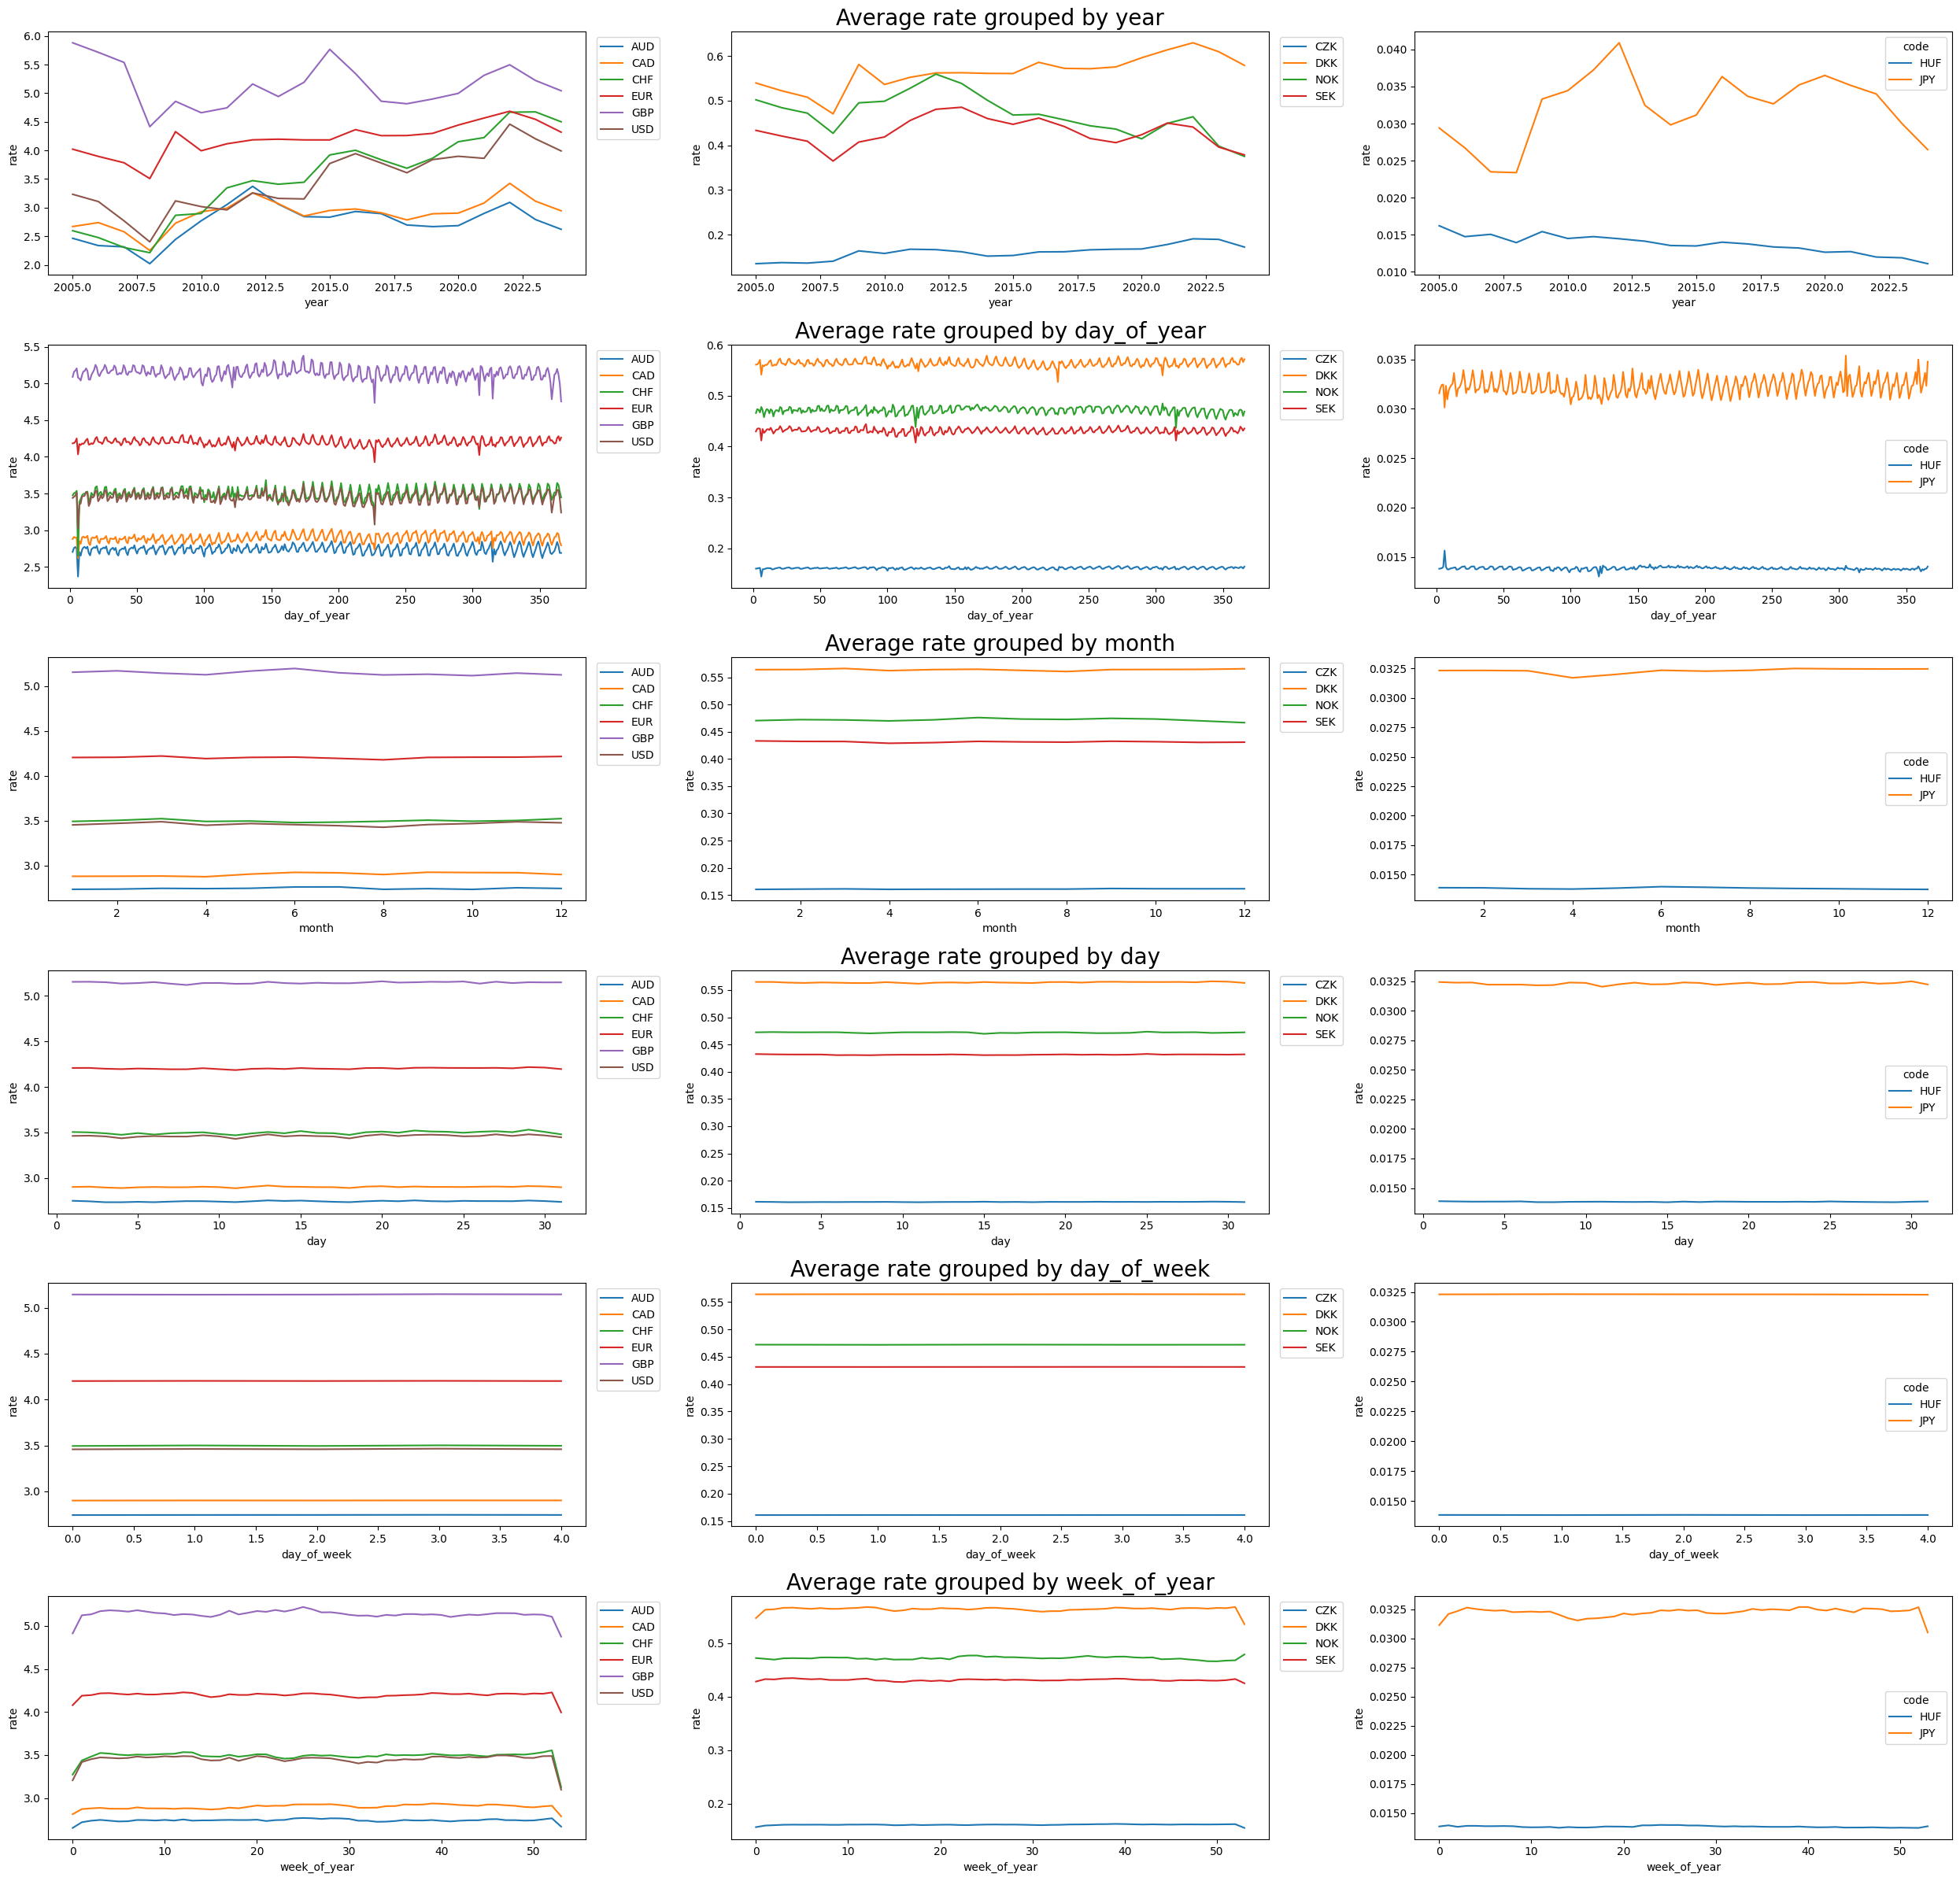

In [18]:
cols = list(df.columns[-6:])

fig,ax = plt.subplots(len(cols),3,figsize=(25,4*len(cols)))

for i,col in enumerate(cols):
    grouped = pd.DataFrame(df.groupby([col,'code'])['rate'].mean()).reset_index()
    g1 = grouped[grouped['rate'] > 1]
    g2 =grouped[(grouped['rate'] < 1) & (grouped['rate'] > 0.1)]
    g3 = grouped[grouped['rate'] < 0.1]
    sns.lineplot(data=g1, x=col,y='rate', hue='code',ax=ax[i,0])
    sns.lineplot(data=g2, x=col,y='rate', hue='code',ax=ax[i,1])
    sns.lineplot(data=g3, x=col,y='rate', hue='code',ax=ax[i,2])
    ax[i,0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    ax[i,1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    ax[i,1].set_title(f'Average rate grouped by {col}',fontsize=20)
    
plt.tight_layout()

Średnia roczna kursów walut pozwala dostrzec trendy zmian wartości.
Średnia dzienna uwypukla komponent sezonowy zmian.
Zastanawiający jest spadek i wzrost wartości kursów wszystkich walut na przełomie ostatniego i pierwszego tygodnia roku, widoczne w ostatnim rzędzie wykresów

Ustawienie daty jako indeksu do dalszej analizy

In [23]:
df = df.rename(columns={'effective_date':'date'})
df = df.set_index('date')
df.head(5)

,ID,no,bid,ask,currency_ID,code,currency,rate,year,day_of_year,month,day,day_of_week,week_of_year
date,,,,,,,,,,,,,,
2005-01-03,3,1/C/NBP/2005,2.3080,2.3546,1,AUD,dolar australijski,2.3313,2005,3,1,3,0,1
2005-01-04,23,2/C/NBP/2005,2.3333,2.3805,1,AUD,dolar australijski,2.3569,2005,4,1,4,1,1
2005-01-05,30,3/C/NBP/2005,2.3407,2.3879,1,AUD,dolar australijski,2.3643,2005,5,1,5,2,1
2005-01-06,43,4/C/NBP/2005,2.3458,2.3932,1,AUD,dolar australijski,2.3695,2005,6,1,6,3,1
2005-01-07,54,5/C/NBP/2005,2.3458,2.3932,1,AUD,dolar australijski,2.3695,2005,7,1,7,4,1


### Rolling windows - średnia, min i max dla różnych wartości okna

Tworzone funkcje okna są przesuwane o jedną próbkę, żeby uniknąć data leakage'u.

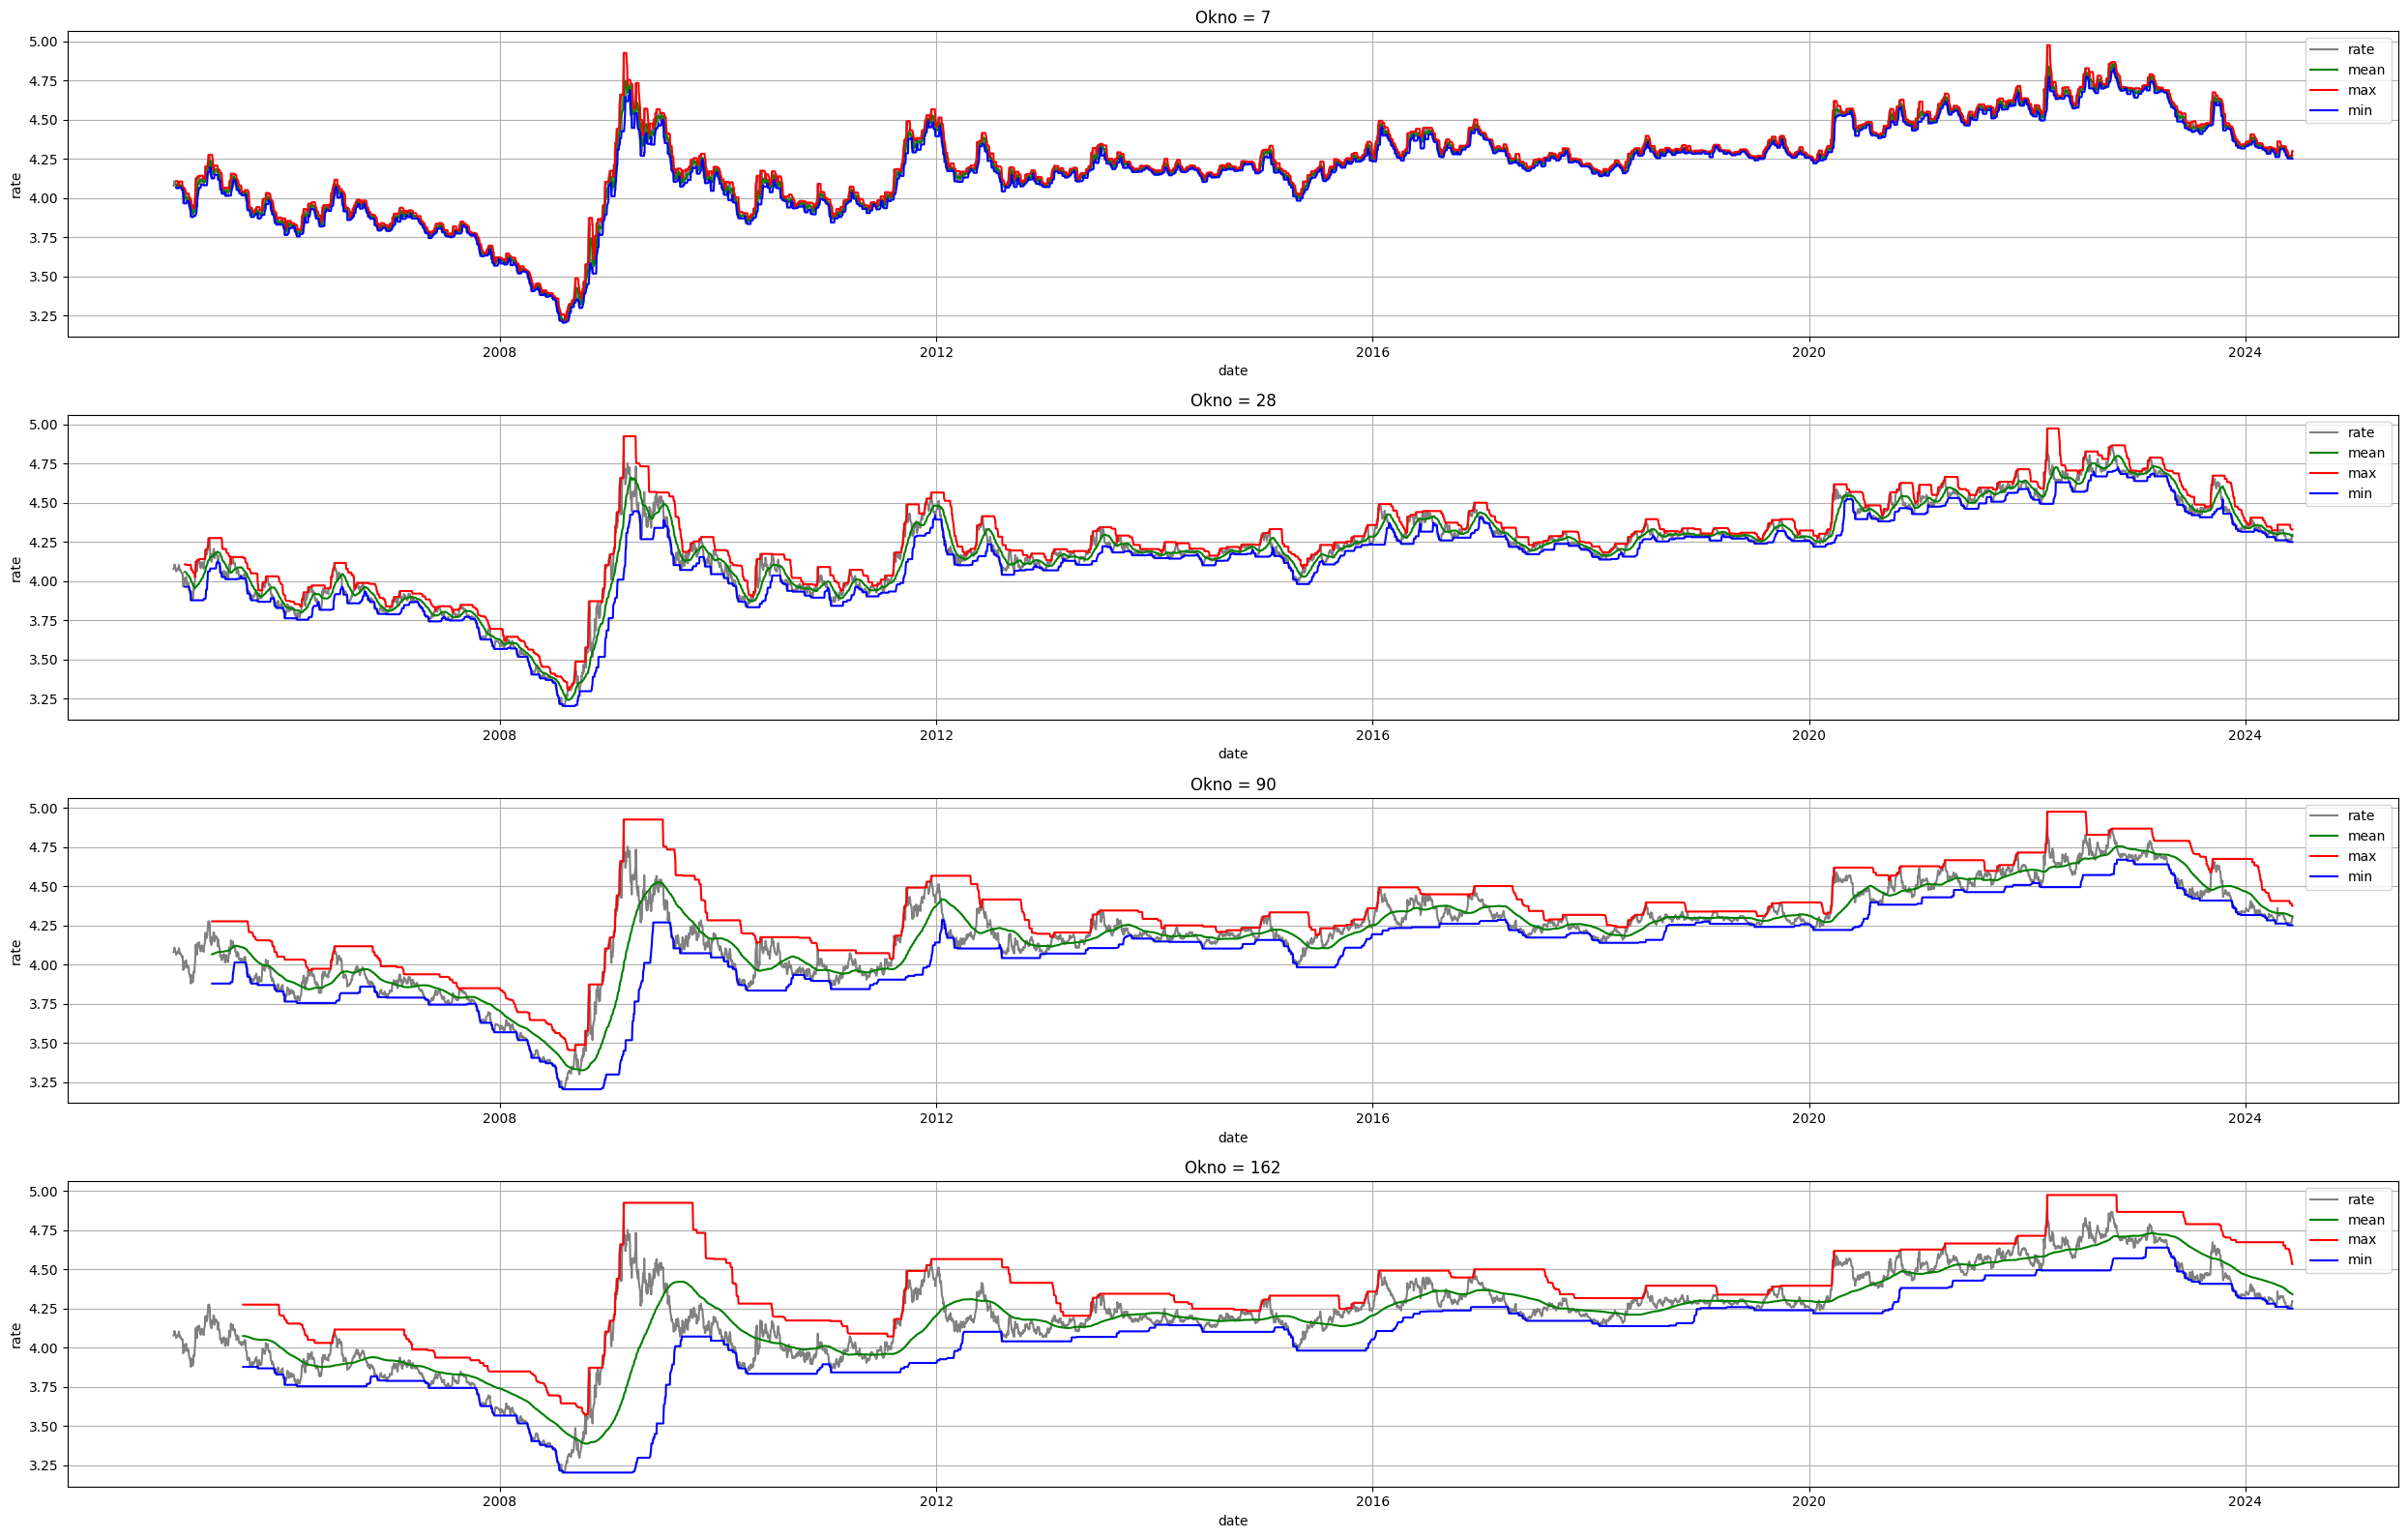

In [24]:
stats = ['mean','min','max']
windows = [7, 28, 90, 162]
colors = ['green','orange','blue']

df_roll = df[df['code'] == 'EUR']
fig, ax = plt.subplots(len(windows), 1, figsize = [25, 4*len(windows)])
for j, window in enumerate(windows):
    

    ax[j].set_title(f'Okno = {window}')
    ax[j].grid()
    # ax[i].set_xlim(np.min(data.index), np.max(data.index))
    
    rolling = pd.DataFrame(df_roll['rate'].rolling(window=window).agg(stats).shift(1).reset_index())

    sns.lineplot(x=df_roll.index,y = df_roll['rate'], ax = ax[j], color = 'grey', label = 'rate')
    sns.lineplot(x = rolling['date'], y = rolling['mean'], ax = ax[j], color = 'green', label = 'mean')
    sns.lineplot(x = rolling['date'], y = rolling['max'], ax = ax[j], color = 'red', label = 'max')
    sns.lineplot(x = rolling['date'], y = rolling['min'], ax = ax[j], color = 'blue', label = 'min')

plt.tight_layout()
plt.show()

Okno 7 dniowe skutkuje, że utworzone sygnały niemal całkowicie dopasowują się do danych, z tego powodu nie zostanie ono dodane.
Jako cechy dodane zostaną okna 28 oraz 90 dni.

In [25]:
df = df.sort_values(by=['code','ID'])

In [26]:
roll_28 = df.groupby('code')['rate'].rolling(window=28,min_periods=1).agg(stats).shift(1).reset_index(level=0)
roll_28.loc['2005-01-03',['mean','min','max']] = np.NaN
df[['roll_mean_28','roll_min_28','roll_max_28']] = roll_28[['mean','min','max']]
roll_90 = df.groupby('code')['rate'].rolling(window=90,min_periods=1).agg(stats).shift(1).reset_index(level=0)
roll_90.loc['2005-01-03',['mean','min','max']] = np.NaN
df[['roll_mean_90','roll_min_90','roll_max_90']] = roll_90[['mean','min','max']]
df

,ID,no,bid,ask,currency_ID,code,currency,rate,year,day_of_year,month,day,day_of_week,week_of_year,roll_mean_28,roll_min_28,roll_max_28,roll_mean_90,roll_min_90,roll_max_90
date,,,,,,,,,,,,,,,,,,,,
2005-01-03,3,1/C/NBP/2005,2.3080,2.3546,1,AUD,dolar australijski,2.3313,2005,3,1,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,23,2/C/NBP/2005,2.3333,2.3805,1,AUD,dolar australijski,2.3569,2005,4,1,4,1,1,2.331300,2.3313,2.3313,2.331300,2.3313,2.3313
2005-01-05,30,3/C/NBP/2005,2.3407,2.3879,1,AUD,dolar australijski,2.3643,2005,5,1,5,2,1,2.344100,2.3313,2.3569,2.344100,2.3313,2.3569
2005-01-06,43,4/C/NBP/2005,2.3458,2.3932,1,AUD,dolar australijski,2.3695,2005,6,1,6,3,1,2.350833,2.3313,2.3643,2.350833,2.3313,2.3643
2005-01-07,54,5/C/NBP/2005,2.3458,2.3932,1,AUD,dolar australijski,2.3695,2005,7,1,7,4,1,2.355500,2.3313,2.3695,2.355500,2.3313,2.3695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,63757,105/C/NBP/2024,3.8984,3.9772,12,USD,dolar amerykański,3.9378,2024,152,5,31,4,22,3.988589,3.9118,4.0730,3.990286,3.9118,4.1019
2024-06-03,63769,106/C/NBP/2024,3.8837,3.9621,12,USD,dolar amerykański,3.9229,2024,155,6,3,0,23,3.983761,3.9118,4.0650,3.989550,3.9118,4.1019
2024-06-04,63784,107/C/NBP/2024,3.9083,3.9873,12,USD,dolar amerykański,3.9478,2024,156,6,4,1,23,3.978686,3.9118,4.0617,3.988198,3.9118,4.1019


In [27]:
df = df.set_index([df.index,'code'])
df = df[~df.index.duplicated(keep='first')]
df = df.reset_index(level=1)
df

,code,ID,no,bid,ask,currency_ID,currency,rate,year,day_of_year,month,day,day_of_week,week_of_year,roll_mean_28,roll_min_28,roll_max_28,roll_mean_90,roll_min_90,roll_max_90
date,,,,,,,,,,,,,,,,,,,,
2005-01-03,AUD,3,1/C/NBP/2005,2.3080,2.3546,1,dolar australijski,2.3313,2005,3,1,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,AUD,23,2/C/NBP/2005,2.3333,2.3805,1,dolar australijski,2.3569,2005,4,1,4,1,1,2.331300,2.3313,2.3313,2.331300,2.3313,2.3313
2005-01-05,AUD,30,3/C/NBP/2005,2.3407,2.3879,1,dolar australijski,2.3643,2005,5,1,5,2,1,2.344100,2.3313,2.3569,2.344100,2.3313,2.3569
2005-01-06,AUD,43,4/C/NBP/2005,2.3458,2.3932,1,dolar australijski,2.3695,2005,6,1,6,3,1,2.350833,2.3313,2.3643,2.350833,2.3313,2.3643
2005-01-07,AUD,54,5/C/NBP/2005,2.3458,2.3932,1,dolar australijski,2.3695,2005,7,1,7,4,1,2.355500,2.3313,2.3695,2.355500,2.3313,2.3695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,USD,63757,105/C/NBP/2024,3.8984,3.9772,12,dolar amerykański,3.9378,2024,152,5,31,4,22,3.988589,3.9118,4.0730,3.990286,3.9118,4.1019
2024-06-03,USD,63769,106/C/NBP/2024,3.8837,3.9621,12,dolar amerykański,3.9229,2024,155,6,3,0,23,3.983761,3.9118,4.0650,3.989550,3.9118,4.1019
2024-06-04,USD,63784,107/C/NBP/2024,3.9083,3.9873,12,dolar amerykański,3.9478,2024,156,6,4,1,23,3.978686,3.9118,4.0617,3.988198,3.9118,4.1019


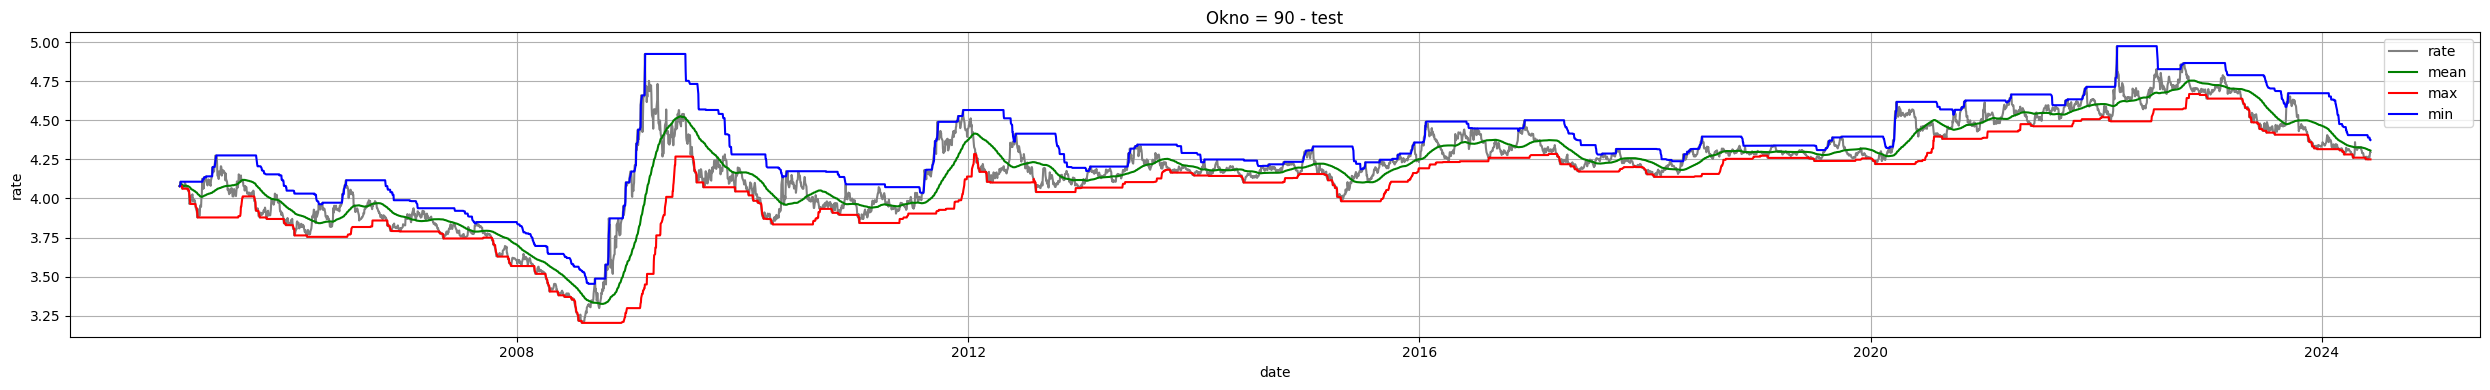

In [28]:
df_roll = df[df['code'] == 'EUR']
df_roll = df_roll[~df_roll.index.duplicated(keep='first')]

fig, ax = plt.subplots(1, 1, figsize = [25, 4])

ax.set_title(f'Okno = 90 - test')
ax.grid()
# ax[i].set_xlim(np.min(data.index), np.max(data.index))

sns.lineplot(x=df_roll.index,y = df_roll['rate'], ax = ax, color = 'grey', label = 'rate')
sns.lineplot(x = df_roll.index, y = df_roll['roll_mean_90'], ax = ax, color = 'green', label = 'mean')
sns.lineplot(x = df_roll.index, y = df_roll['roll_min_90'], ax = ax, color = 'red', label = 'max')
sns.lineplot(x = df_roll.index, y = df_roll['roll_max_90'], ax = ax, color = 'blue', label = 'min')

plt.tight_layout()
plt.show()

Ze względu na wystąpienie duplikatów w danych musiały one zostać usunięte, a powyższy wykres sprawdza, czy dane są poprawne po tej transformacji

### Autokorelacja (ACF)

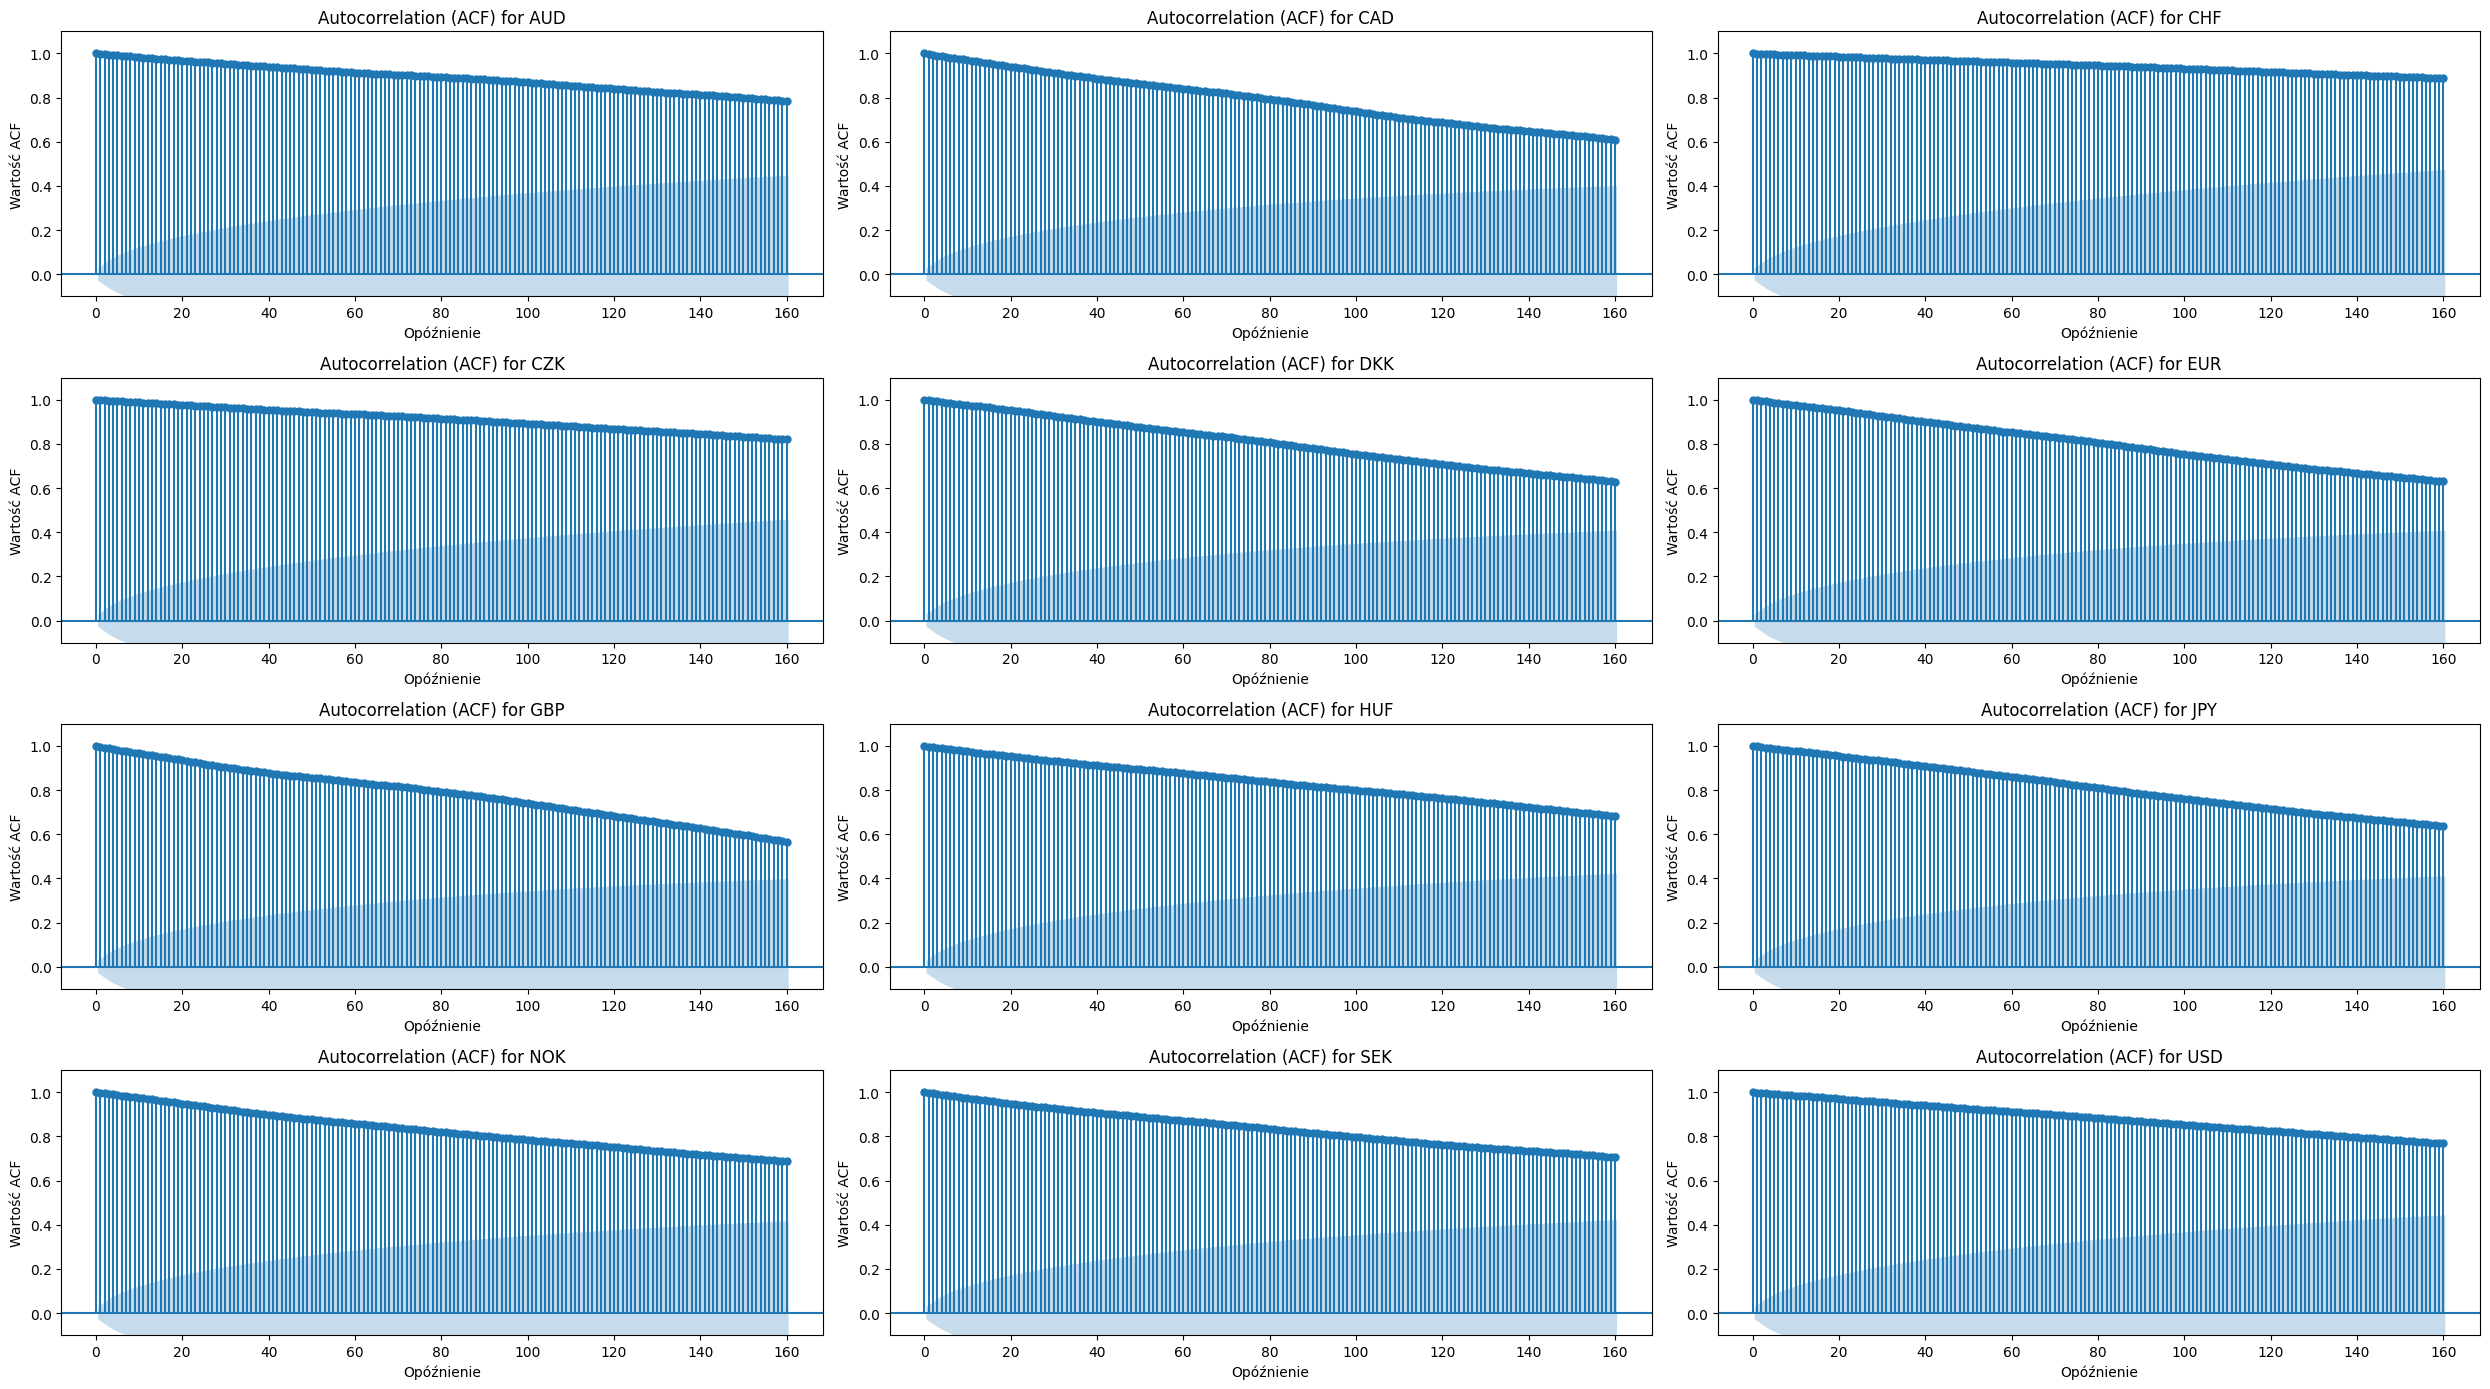

In [29]:
fig,ax = plt.subplots(4,3, figsize = (25,14))
axs = ax.flatten()
for i,code in enumerate(list(df['code'].unique())):
    plot_acf(df[df['code'] == code]['rate'], lags=160, ax=axs[i])
    axs[i].set_title(f"Autocorrelation (ACF) for {code}")
    axs[i].set_xlabel("Opóźnienie")
    axs[i].set_ylabel("Wartość ACF")
    axs[i].set_ylim([-0.1,1.1])
plt.tight_layout()

Jak widać, dla żadnej z walut nie wyróżniają się lokalne maksima funkcji autokorelacji, które mogłyby zostać dodane do modelu. Z tego powodu wybrane zostało 28 opóźnienie sygnału i dodane jako cecha

In [42]:
df['lag_28'] = df.groupby('code')['rate'].shift(28)
df.head(5)
df.columns

Index(['code', 'ID', 'no', 'bid', 'ask', 'currency_ID', 'currency', 'rate',
       'year', 'day_of_year', 'month', 'day', 'day_of_week', 'week_of_year',
       'roll_mean_28', 'roll_min_28', 'roll_max_28', 'roll_mean_90',
       'roll_min_90', 'roll_max_90', 'lag_28'],
      dtype='object')

# Tworzenie modelu predykcyjnego

Do utworzenia modelu wykorzystany zostanie algorytm predykcyjny xgboost

In [43]:
df2 = df[['code','rate','year', 'day_of_year', 'month', 'day', 'day_of_week', 'week_of_year',
       'roll_mean_28', 'roll_min_28', 'roll_max_28', 'roll_mean_90',
       'roll_min_90', 'roll_max_90', 'lag_28']]
df2 = df2.sort_index()
df2 = df2.set_index([df2.index,'code'])
df2

rate  year  day_of_year  month  day  day_of_week  \
date       code                                                         
2005-01-03 AUD   2.331300  2005            3      1    3            0   
           CZK   0.134100  2005            3      1    3            0   
           HUF   0.016590  2005            3      1    3            0   
           JPY   0.029168  2005            3      1    3            0   
           DKK   0.548300  2005            3      1    3            0   
...                   ...   ...          ...    ...  ...          ...   
2024-06-06 CHF   4.424500  2024          158      6    6            3   
           CAD   2.879400  2024          158      6    6            3   
           AUD   2.623900  2024          158      6    6            3   
           SEK   0.379800  2024          158      6    6            3   
           USD   3.946000  2024          158      6    6            3   

                 week_of_year  roll_mean_28  roll_min_28  roll_max_28  \
date       code                                                         
2005-01-03 AUD              1           NaN          NaN          NaN   
           CZK              1           NaN          NaN          NaN   
           HUF              1           NaN          NaN          NaN   
           JPY              1           NaN          NaN          NaN   
           DKK              1           NaN          NaN          NaN   
...                       ...           ...          ...          ...   
2024-06-06 CHF             23      4.369279       4.2925       4.4370   
           CAD             23      2.905207       2.8679       2.9587   
           AUD             23      2.623671       2.5979       2.6510   
           SEK             23      0.369179       0.3647       0.3781   
           USD             23      3.971379       3.9118       4.0507   

                 roll_mean_90  roll_min_90  roll_max_90  lag_28  
date       code                                                  
2005-01-03 AUD            NaN          NaN          NaN     NaN  
           CZK            NaN          NaN          NaN     NaN  
           HUF            NaN          NaN          NaN     NaN  
           JPY            NaN          NaN          NaN     NaN  
           DKK            NaN          NaN          NaN     NaN  
...                       ...          ...          ...     ...  
2024-06-06 CHF       4.457603       4.2925       4.6786  4.4291  
           CAD       2.934100       2.8679       3.0066  2.9477  
           AUD       2.613630       2.5852       2.6635  2.6110  
           SEK       0.376647       0.3647       0.3874  0.3719  
           USD       3.986697       3.9118       4.1019  4.0280  

[58896 rows x 14 columns]

Podział na zbiory uczący i testowy z zachowaniem chronologii w danych

In [44]:
X = df2.drop(columns=['rate'])
y = df2['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False)

X_train

year  day_of_year  month  day  day_of_week  week_of_year  \
date       code                                                             
2005-01-03 AUD   2005            3      1    3            0             1   
           CZK   2005            3      1    3            0             1   
           HUF   2005            3      1    3            0             1   
           JPY   2005            3      1    3            0             1   
           DKK   2005            3      1    3            0             1   
...               ...          ...    ...  ...          ...           ...   
2020-07-20 DKK   2020          202      7   20            0            29   
2020-07-21 AUD   2020          203      7   21            1            29   
           EUR   2020          203      7   21            1            29   
           CAD   2020          203      7   21            1            29   
           DKK   2020          203      7   21            1            29   

                 roll_mean_28  roll_min_28  roll_max_28  roll_mean_90  \
date       code                                                         
2005-01-03 AUD            NaN          NaN          NaN           NaN   
           CZK            NaN          NaN          NaN           NaN   
           HUF            NaN          NaN          NaN           NaN   
           JPY            NaN          NaN          NaN           NaN   
           DKK            NaN          NaN          NaN           NaN   
...                       ...          ...          ...           ...   
2020-07-20 DKK       0.598521       0.5944       0.6023      0.602922   
2020-07-21 AUD       2.737343       2.6992       2.7593      2.663250   
           EUR       4.462232       4.4335       4.4840      4.499034   
           CAD       2.911186       2.8833       2.9333      2.936667   
           DKK       0.598782       0.5946       0.6023      0.603186   

                 roll_min_90  roll_max_90  lag_28  
date       code                                    
2005-01-03 AUD           NaN          NaN     NaN  
           CZK           NaN          NaN     NaN  
           HUF           NaN          NaN     NaN  
           JPY           NaN          NaN     NaN  
           DKK           NaN          NaN     NaN  
...                      ...          ...     ...  
2020-07-20 DKK        0.5780       0.6181  0.5944  
2020-07-21 AUD        2.4343       2.7593  2.7234  
           EUR        4.3191       4.6180  4.4428  
           CAD        2.7777       3.0144  2.9138  
           DKK        0.5780       0.6181  0.5958  

[47116 rows x 13 columns]

Text(0.5, 1.0, 'Zbiory uczący i testowy dla waluty USD')

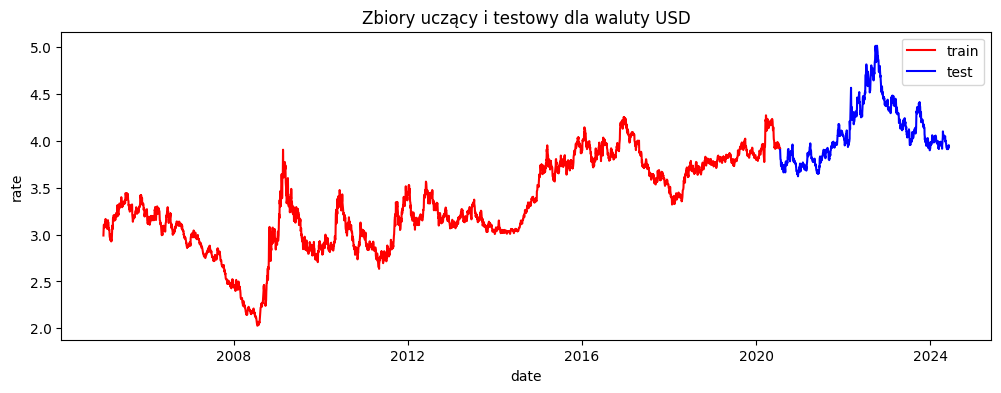

In [45]:
fig, ax = plt.subplots(1,1, figsize = [12, 4])
sns.lineplot(x=y_train.loc[(slice(None),'USD')].index.get_level_values(0),y=y_train.loc[(slice(None),'USD')], ax = ax, color = 'red',label = 'train')
sns.lineplot(x=y_test.loc[(slice(None),'USD')].index.get_level_values(0),y=y_test.loc[(slice(None),'USD')], ax = ax, color = 'blue', label = 'test')
ax.set_title('Zbiory uczący i testowy dla waluty USD')

Trenowanie modelu do predykcji

In [46]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Błąd średniokwadratowy (MSE):", mse)
print("Współczynnik determinacji (R2):", r2)

Błąd średniokwadratowy (MSE): 0.0038339437085810426
Współczynnik determinacji (R2): 0.9990358305703757


Stworzony model odznacza się ogromnie dużym współczynnikiem R2, co nie jest dobrym sygnałem - model należy poddać walidacji

In [47]:
tscv = TimeSeriesSplit(n_splits=6)


mse_list = []
r2_list = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)

    print("Błąd średniokwadratowy (MSE):", mse)
    print("Współczynnik determinacji (R2):", r2)
    
print("Średni błąd średniokwadratowy (MSE) walidacji:", sum(mse_list)/len(mse_list))
print("Średni współczynnik determinacji (R2) walidacji:", sum(r2_list)/len(r2_list))

Błąd średniokwadratowy (MSE): 0.32316056457630093
Współczynnik determinacji (R2): 0.8718216165367673
Błąd średniokwadratowy (MSE): 0.004854327296130851
Współczynnik determinacji (R2): 0.9984018399272147
Błąd średniokwadratowy (MSE): 0.0035452189711876504
Współczynnik determinacji (R2): 0.9989547288858023
Błąd średniokwadratowy (MSE): 0.0028442704042388038
Współczynnik determinacji (R2): 0.9991554106451602
Błąd średniokwadratowy (MSE): 0.0018696882162838036
Współczynnik determinacji (R2): 0.9994658979273909
Błąd średniokwadratowy (MSE): 0.0033243295707100426
Współczynnik determinacji (R2): 0.9991914588388067
Średni błąd średniokwadratowy (MSE) walidacji: 0.056599733172475346
Średni współczynnik determinacji (R2) walidacji: 0.9778318254601904


Walidacja przy innym podziale danych również wskazuje na niemal idealne dopasowanie, co może wskazywać na overfitting modelu - dopasowywanie się do szumu

Porównanie wartości predykowanej i rzeczywistej

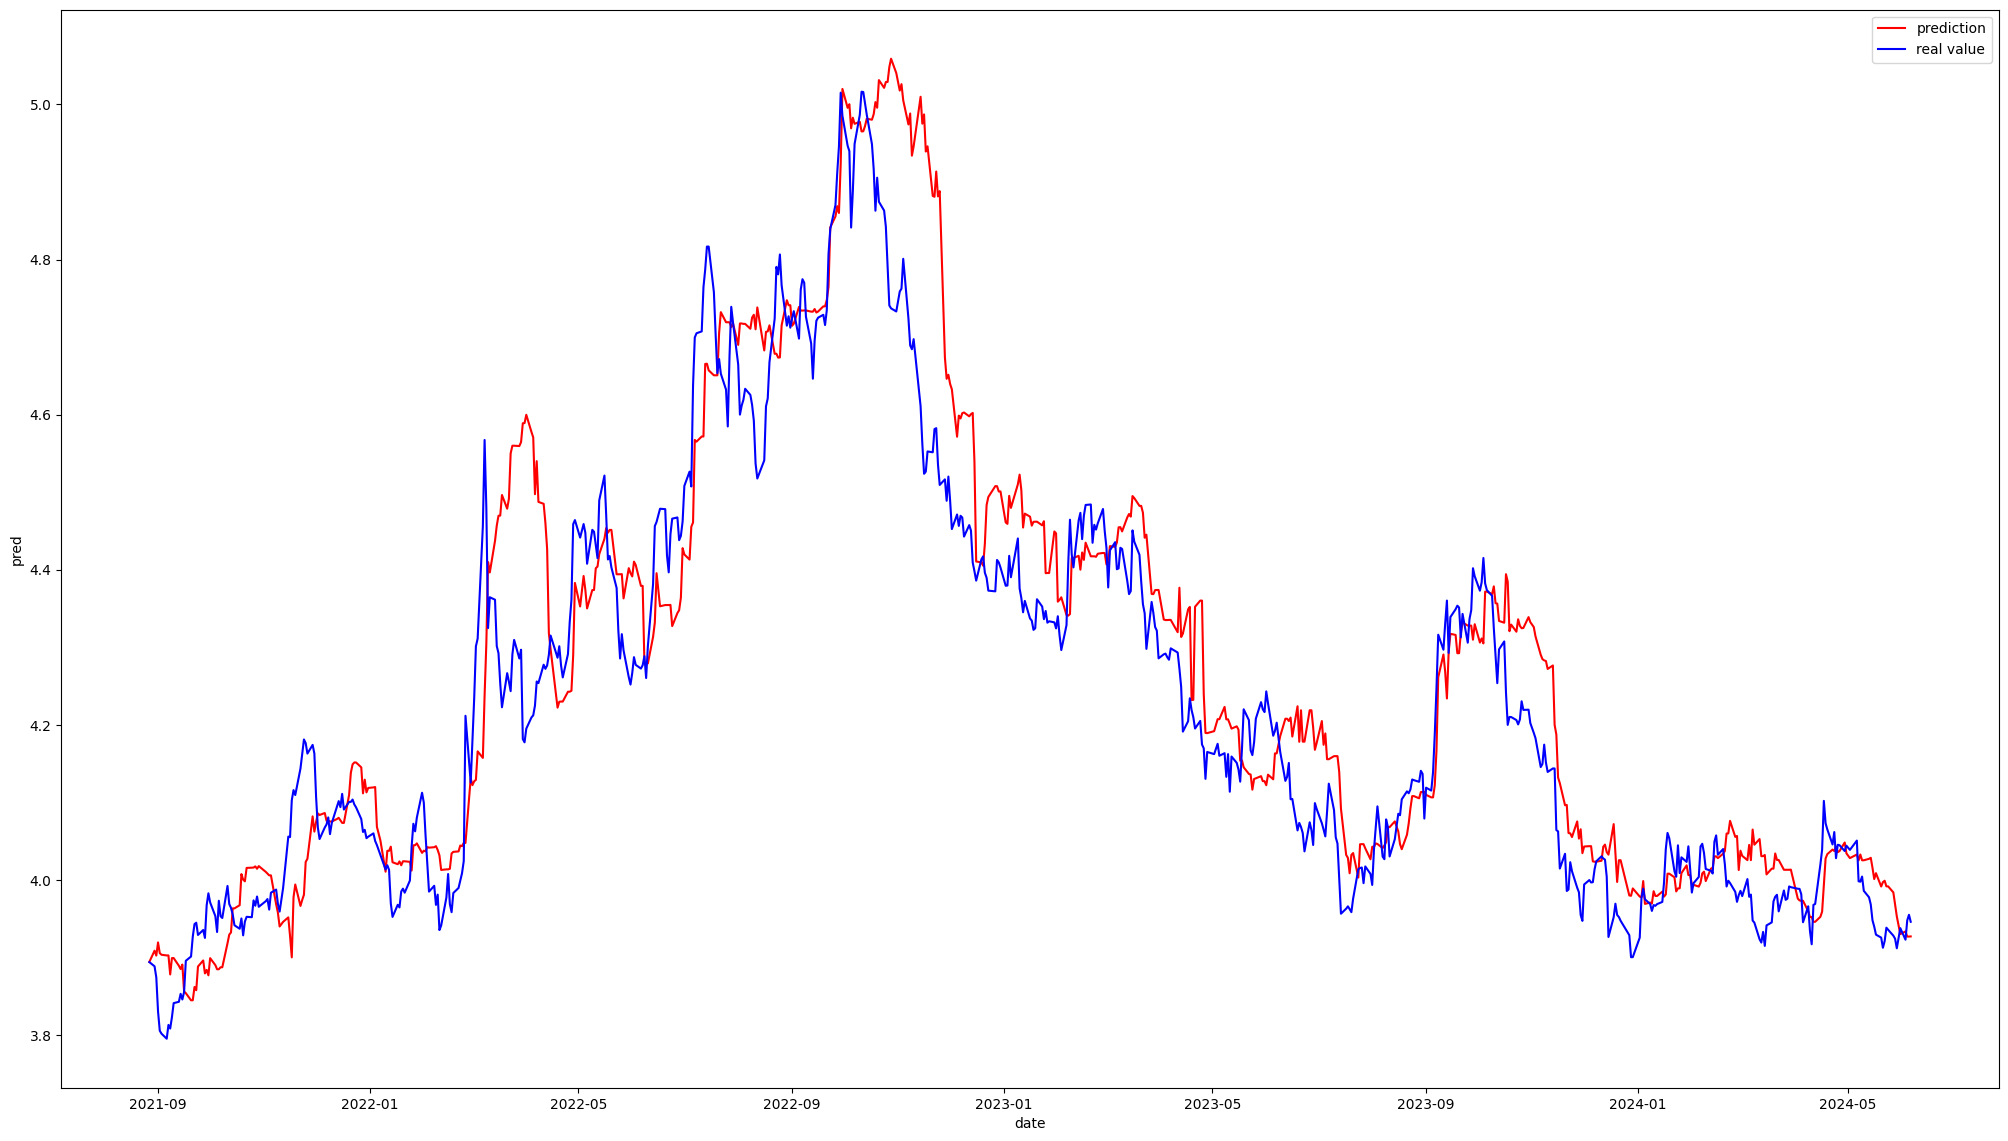

In [48]:
codes = y_test.reset_index()['code'].unique()
codes = ['USD']
res = pd.DataFrame(y_test)
res['pred'] = y_pred

fig,ax = plt.subplots(1,1, figsize = (25,14))

for i,code in enumerate(codes):
    sns.lineplot(x=res.loc[(slice(None),code),:].index.get_level_values(0),y=res.loc[(slice(None),code),'pred'], ax = ax, color = 'red',label = 'prediction')
    sns.lineplot(x=res.loc[(slice(None),code),:].index.get_level_values(0),y=res.loc[(slice(None),code),'rate'], ax = ax, color = 'blue',label = 'real value')

Pomimo tak wysokiego współczynnika determinacji model nie wpasowuje się idealnie do danych testowych, ale widoczne jest, że z niewielkim opóźnieniem przewiduje trend zmian wartości waluty.

In [49]:
feature_importance = model.feature_importances_

cols = list(X.columns)
for i, imp in enumerate(feature_importance):
    print(f"Istotność cechy {cols[i]}: {np.round(float(imp),3)}")

Istotność cechy year: 0.0
Istotność cechy day_of_year: 0.0
Istotność cechy month: 0.0
Istotność cechy day: 0.0
Istotność cechy day_of_week: 0.0
Istotność cechy week_of_year: 0.0
Istotność cechy roll_mean_28: 0.059
Istotność cechy roll_min_28: 0.61
Istotność cechy roll_max_28: 0.052
Istotność cechy roll_mean_90: 0.0
Istotność cechy roll_min_90: 0.001
Istotność cechy roll_max_90: 0.277
Istotność cechy lag_28: 0.0


najważniejszymi cechami dla modelu są roll_min_28 oraz roll_max_90